Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Example Tutorial for Australian Domestic Tourism
[1] https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourism.html


For Non-Negative Reconcilitation.
[3] https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/nonnegativereconciliation.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models.forecasting.arima import ARIMA
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, plot_acf

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, NaiveSeasonal
from darts.utils.utils import ModelMode
# from darts.utils.likelihood_models import GaussianLikelihood
from darts.dataprocessing.transformers import Scaler

import numpy as np
import pandas as pd

from functools import partial

from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.utils import HierarchicalPlot, is_strictly_hierarchical

from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast
# from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, ADIDA, CrostonClassic, TSB

from utilsforecast.losses import scaled_crps
from utilsforecast.losses import rmse, mase, msse

import warnings

import datetime

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL

import os
from pathlib import Path


pd.set_option('display.max_columns', 500)


Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/user/virtualenvs/lh_desafio_ds_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data_processing import resample_time_series, fill_timeseries_gaps, fill_missing_dates

In [3]:
curr_folder_path = Path(os.path.abspath(""))
base_path = curr_folder_path.parent.absolute()
data_path = os.path.join(base_path, 'data')

df_ds1 = pd.read_csv(os.path.join(data_path, 'dim_ds_new.csv'))

df_ds1.sample(3)

,SALES_ORDER_ID,ACCOUNT_NUMBER,BILL_TO_ADDRESS_ID,CREDITCARD_ID,CUSTOMER_ID,CURRENCY_RATE_ID,DUE_DATE,FREIGHT,ONLINE_ORDER_FLAG,ORDER_DATE,SALES_PERSON_ID,SHIP_DATE,SHIP_TO_ADDRESS_ID,SHIP_METHOD_ID,SALES_STATUS,SUBTOTAL,TERRITORY_ID,TAXAMT,TOTAL_DUE,PRODUCT_ID,SALES_ORDER_DETAIL_ID,ORDER_QTY,SPECIAL_OFFER_ID,UNIT_PRICE,UNIT_PRICE_DISCOUNT,PRODUCT_CLASS,PRODUCT_COLOR,DAY_TO_MANUFACTURE,FINISHED_GOODS_FLAG,LIST_PRICE,PRODUCT_NAME,PRODUCT_LINE,PRODUCT_MODEL_ID,PRODUCT_NUMBER,PRODUCT_SUBCATEGORY_ID,SELL_END_DATE,SELL_START_DATE,PRODUCT_SIZE,SIZE_UNIT_MEASURE_CODE,STANDARD_COST,PRODUCT_STYLE,PRODUCT_WEIGHT,WEIGHT_UNIT_MEASURE_CODE,PERSON_ID,STORE_ID,BUSINESS_ENTITY_ID,STORE_NAME,TERRITORY_NAME,COUNTRY_REGION_CODE,TERRITORY_GROUP,SALES_YTD,SALES_LAST_YEAR,COST_YTD,COST_LAST_YEAR,STATEPROVINCE_ID,STATEPROVINCE_NAME,STATEPROVINCE_CODE,COUNTRYREGION_CODE,IS_PROVINCE_FLAG,COUNTRY_REGION_NAME,ADDRESS_ID,ADDRESSLINE_FULL,CITY,POSTALCODE
2808,59074,10-4020-000054,760,3788.0,29966,NaN,2013-11-11 00:00:00.000,1093.2680,False,2013-10-30,277.0,2013-11-06,760,5,5,36682.5594,2,3498.4575,41274.2849,883,70398,4,1,32.3940,0.0,NaN,Yellow,0,True,53.99,"Short-Sleeve Classic Jersey, L",S,32,SJ-0194-L,21,NaN,2013-05-30 00:00:00.000,L,NaN,41.5723,U,NaN,NaN,1355,1356.0,1356.0,Larger Cycle Shop,Northeast,US,group,2.402177e+06,3.607149e+06,0,0,54,New York,NY,US,False,United States,760,"Attn: Accounts Payable, Attn: Accounts Payable",Melville,11747
119303,49955,10-4030-015152,27878,2019.0,15152,7465.0,2013-03-18 00:00:00.000,51.2275,True,2013-03-06,NaN,2013-03-13,27878,1,5,2049.0982,9,163.9279,2264.2536,783,30664,1,1,2049.0982,0.0,H,Black,4,True,2294.99,"Mountain-200 Black, 42",M,20,BK-M68B-42,1,NaN,2012-05-30 00:00:00.000,42,CM,1251.9813,U,23.77,LB,18790,NaN,NaN,NaN,Australia,AU,group,5.977815e+06,2.278549e+06,0,0,77,Victoria,VIC,AU,False,Australia,27878,"8048 Shepberry Court, 8048 Shepberry Court",Warrnambool,3280
28273,65819,10-4030-028084,26614,12719.0,28084,NaN,2014-02-18 00:00:00.000,1.5118,True,2014-02-06,NaN,2014-02-13,26614,1,5,60.4700,4,4.8376,66.8194,922,91791,1,1,3.9900,0.0,NaN,NaN,0,True,3.99,Road Tire Tube,R,93,TT-R982,37,NaN,2013-05-30 00:00:00.000,NaN,NaN,1.4923,NaN,NaN,NaN,17528,NaN,NaN,NaN,Southwest,US,group,1.051085e+07,5.366576e+06,0,0,9,California,CA,US,False,United States,26614,"9761 Fox Way, 9761 Fox Way",Berkeley,94704


## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Data Science Task #2</p>

Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.



In [4]:
TIME_COL = "ORDER_DATE"
TARGET_COLS = "ORDER_QTY"
FREQ = 'MS'
HORIZON = 4


LEVEL = np.arange(0, 100, 2)

## Data Processing

Simple data processing to make the dataset clean and contiguous in order to be used in modeling or other stages

In [5]:

# Select only relevant columns
df = df_ds1[['PRODUCT_NAME', TARGET_COLS, TIME_COL, 'STORE_NAME']]

# Select Products, Stores or Store/Product combination
unique_combinations = df.groupby(['STORE_NAME', 'PRODUCT_NAME']).size()
filtered_combinations = unique_combinations[unique_combinations > 11].index
df = df[df.set_index(['STORE_NAME', 'PRODUCT_NAME']).index.isin(filtered_combinations)]

# Datetime casting
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# Filling empty stores
df['STORE_NAME'] = df['STORE_NAME'].fillna('E-commerce')

# Fill missing dates
start_date = df[TIME_COL].min()
end_date = df[TIME_COL].max()
df = fill_timeseries_gaps(df, time_col=TIME_COL, target_cols=TARGET_COLS, start_date=start_date, end_date=end_date)

# Resample
df = resample_time_series(df, frequency=FREQ, time_col=TIME_COL, target_cols=TARGET_COLS)

df


,ORDER_DATE,PRODUCT_NAME,STORE_NAME,ORDER_QTY
0,2011-05-01,AWC Logo Cap,Advanced Bike Components,0.0
1,2011-05-01,AWC Logo Cap,Better Bike Shop,2.0
2,2011-05-01,AWC Logo Cap,Bike Dealers Association,6.0
3,2011-05-01,AWC Logo Cap,Farthermost Bike Shop,0.0
4,2011-05-01,AWC Logo Cap,Resale Services,0.0
...,...,...,...,...
1771,2014-05-01,"Sport-100 Helmet, Red",Bike Dealers Association,0.0
1772,2014-05-01,"Sport-100 Helmet, Red",Larger Cycle Shop,2.0
1773,2014-05-01,"Sport-100 Helmet, Red",Rapid Bikes,4.0
1774,2014-05-01,"Sport-100 Helmet, Red",Rewarding Activities Company,0.0


### Visualizing the Time Series

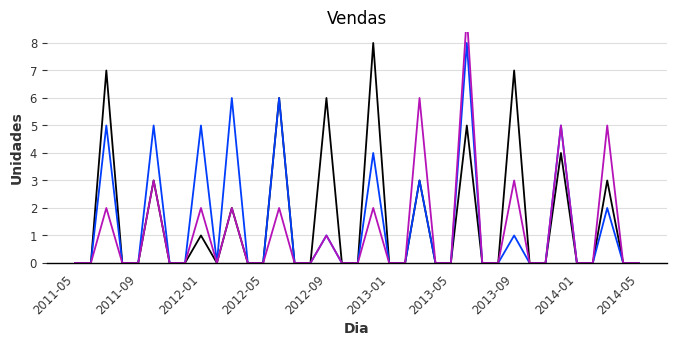

In [6]:
example_store = 'The Gear Store' # Option 1
# example_store = 'Fitness Toy Store' # Option 2

specific_store_df = df[df['STORE_NAME'] == example_store]

plt.figure(figsize=(8, 3))

for product in specific_store_df['PRODUCT_NAME'].unique():
    _df = specific_store_df[specific_store_df['PRODUCT_NAME'] == product]
    sns.lineplot(x=TIME_COL, y=TARGET_COLS, data=_df, errorbar=None) #, color=cerulean
    sns.despine(left=True)

    plt.title('Vendas')
    plt.xlabel('Dia')
    plt.ylabel('Unidades')
    plt.ylim(0, None)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='x')

plt.show()

## Encoding the Hierarchy

,unique_id,ORDER_DATE,ORDER_QTY
0,Advanced Bike Components,2011-05-01,0.0
1,Advanced Bike Components,2011-06-01,0.0
2,Advanced Bike Components,2011-07-01,0.0
3,Advanced Bike Components,2011-08-01,5.0
4,Advanced Bike Components,2011-09-01,0.0


S_df.shape: (63, 49)


,unique_id,Advanced Bike Components/AWC Logo Cap,"Advanced Bike Components/Sport-100 Helmet, Blue",Better Bike Shop/AWC Logo Cap,Bike Dealers Association/AWC Logo Cap
0,Advanced Bike Components,1.0,1.0,0.0,0.0
1,Better Bike Shop,0.0,0.0,1.0,0.0
2,Bike Dealers Association,0.0,0.0,0.0,1.0
3,Farthermost Bike Shop,0.0,0.0,0.0,0.0
4,Fitness Toy Store,0.0,0.0,0.0,0.0


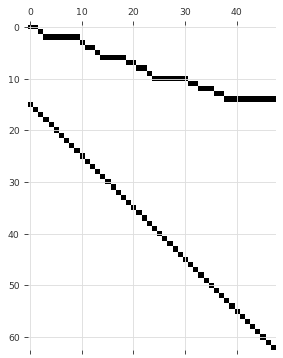

In [7]:
spec = [
    ['STORE_NAME'],
    ['STORE_NAME', 'PRODUCT_NAME'],
]

Y_df, S_df, tags = aggregate(
    df,
    spec,
    time_col=TIME_COL,
    target_cols=[TARGET_COLS]
)

reconcilers = [
    BottomUp(),
    # TopDown(method='average_proportions'),
    # TopDown(method='proportion_averages'),
    # MinTrace(method='ols'),
    # MinTrace(method='ols', nonnegative=True),
    # MinTrace(method='wls_var'),
    # MinTrace(method='mint_shrink'),
    # ERM(method='closed')
]

eval_tags = {}
eval_tags['Total'] = tags['STORE_NAME']
eval_tags['PRODUCT_NAME'] = tags['STORE_NAME/PRODUCT_NAME']

display(Y_df.head())
print(f"S_df.shape: {S_df.shape}")
display(S_df.iloc[:5, :5])

hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

## Train Test Separation

In [8]:
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_train_df


,unique_id,ORDER_DATE,ORDER_QTY
0,Advanced Bike Components,2011-05-01,0.0
1,Advanced Bike Components,2011-06-01,0.0
2,Advanced Bike Components,2011-07-01,0.0
3,Advanced Bike Components,2011-08-01,5.0
4,Advanced Bike Components,2011-09-01,0.0
...,...,...,...
2322,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-09-01,0.0
2323,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-10-01,9.0
2324,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-11-01,0.0
2325,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-12-01,0.0


## Modeling

In [9]:
models = [LinearRegression(),]
model_names = [m.__class__.__name__ for m in models]

fcst = MLForecast(
    models=models,
    freq=FREQ,
    lags=[1,2,3,12], #,24
    # date_features=[TIME_COL],
)
fcst.fit(
    Y_train_df,
    fitted=True,
    prediction_intervals=PredictionIntervals(n_windows=4, h=HORIZON),
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

Y_hat_df = fcst.predict(HORIZON, level=LEVEL) #
insample_df = fcst.forecast_fitted_values()

/home/user/virtualenvs/lh_desafio_ds_venv/lib/python3.11/site-packages/utilsforecast/processing.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[names] = values
/home/user/virtualenvs/lh_desafio_ds_venv/lib/python3.11/site-packages/utilsforecast/processing.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[names] = values
/home/user/virtualenvs/lh_desafio_ds_venv/lib/python3.11/site-packages/utilsforecast/processing.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

### Evaluation

In [10]:
# Evaluate without reconciliation

df = Y_hat_df.merge(Y_test_df, on=['unique_id', TIME_COL])
evaluation = evaluate(
    df = df,
    tags = eval_tags,
    train_df = Y_train_df,
    metrics = [rmse, partial(mase, seasonality=4)],
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

# evaluation.columns = ['level', 'metric'] + model_names
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

display(evaluation.query('metric == "rmse"'))
display(evaluation.query('metric == "mase"'))


,level,metric,LinearRegression
0,Total,rmse,10.88
2,PRODUCT_NAME,rmse,3.66
4,Overall,rmse,5.38


,level,metric,LinearRegression
1,Total,mase,0.80
3,PRODUCT_NAME,mase,0.81
5,Overall,mase,0.81


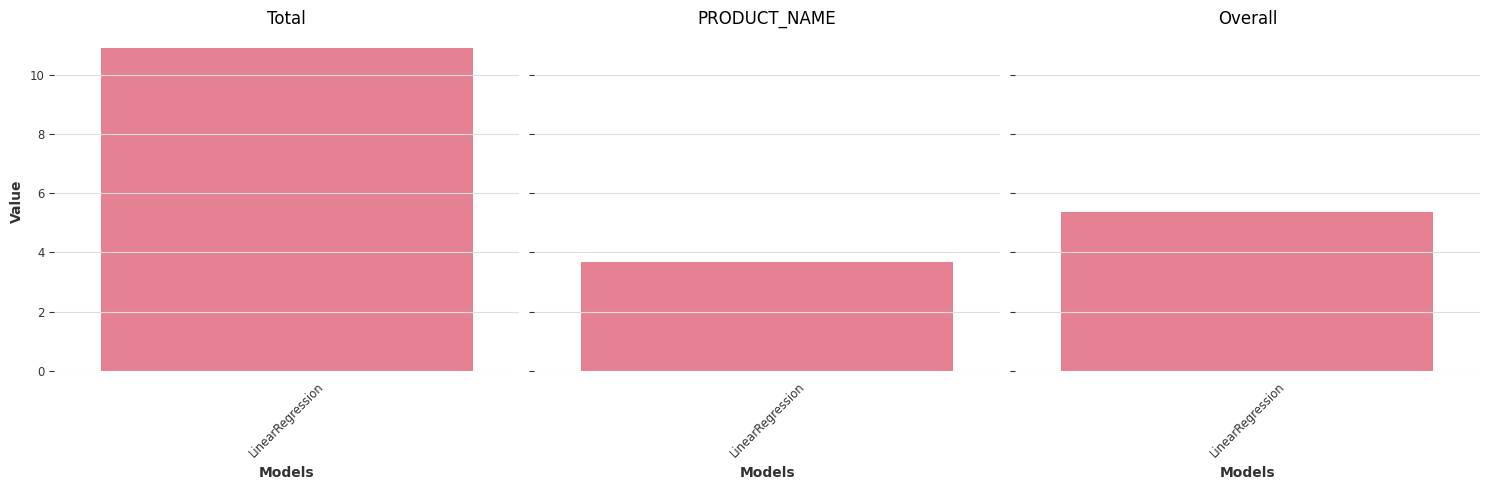

In [11]:
# Dataviz

eval_df = evaluation.query('metric == "rmse"')

df = eval_df

# Melt the dataframe for seaborn
melted_df = df.melt(id_vars=['level', 'metric'], var_name='Model', value_name='Value')

# Set up the figure and axes
palette = sns.color_palette("husl", n_colors=len(melted_df['Model'].unique()))
fig, axes = plt.subplots(1, len(df['level'].unique()), figsize=(15, 5), sharey=True)

# Loop through levels to create grouped barplots
for i, (ax, level) in enumerate(zip(axes, df['level'].unique())):
    
    # Filter data for the current level
    level_data = melted_df[melted_df['level'] == level]
    
    # Create barplot
    sns.barplot(
        data=level_data,
        x='Model',
        y='Value',
        hue='Model',
        ax=ax,
        palette=palette,
        dodge=False
    )
    
    # Customize each subplot
    ax.set_title(level)
    ax.set_ylabel('Value') if i == 0 else ax.set_ylabel('')  # Only show y-axis label for the first subplot
    ax.set_xlabel('Models')
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


## Reconciliation

In [12]:
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=insample_df,
    S=S_df,
    tags=tags,
    level=LEVEL,
    id_col="unique_id",
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

### Evaluation

In [13]:
rec_model_names_mf = ['LinearRegression/BottomUp'] #, 'LinearRegression/MinTrace_method-mint_shrink', 'LinearRegression/ERM_method-closed_lambda_reg-0.01']

eval_df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL])

evaluation_mf = evaluate(
    df=eval_df,
    tags=tags,
    metrics=[scaled_crps],
    models=rec_model_names_mf,
    level=LEVEL,
    id_col="unique_id",
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

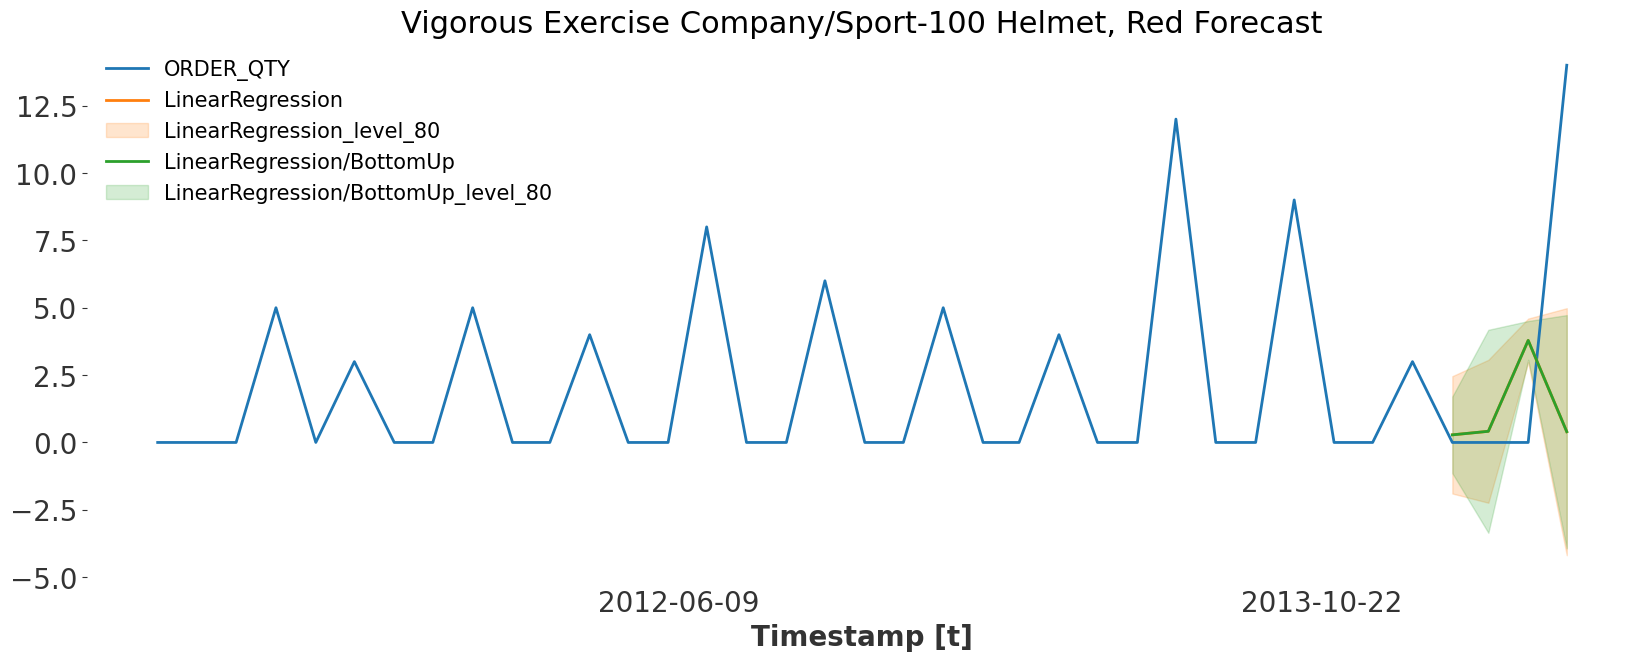

In [14]:
# Visualizations

plot_mf = Y_df.merge(Y_rec_df, on=['unique_id', TIME_COL], how="outer")
plot_mf.head(3)

hplot.plot_series(
    series='Vigorous Exercise Company/Sport-100 Helmet, Red',
    Y_df=plot_mf, 
    models=[TARGET_COLS, 'LinearRegression', 'LinearRegression/BottomUp'],
    level=[80],
    id_col="unique_id",
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

ax = plt.gca()
# ax.set_xlim([datetime.date(2014, 1, 30), datetime.date(2014, 6, 30)])
